In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [2]:
df = pd.read_csv('train.csv')
df.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [3]:
# Shape of the data
df.shape

(1000, 12)

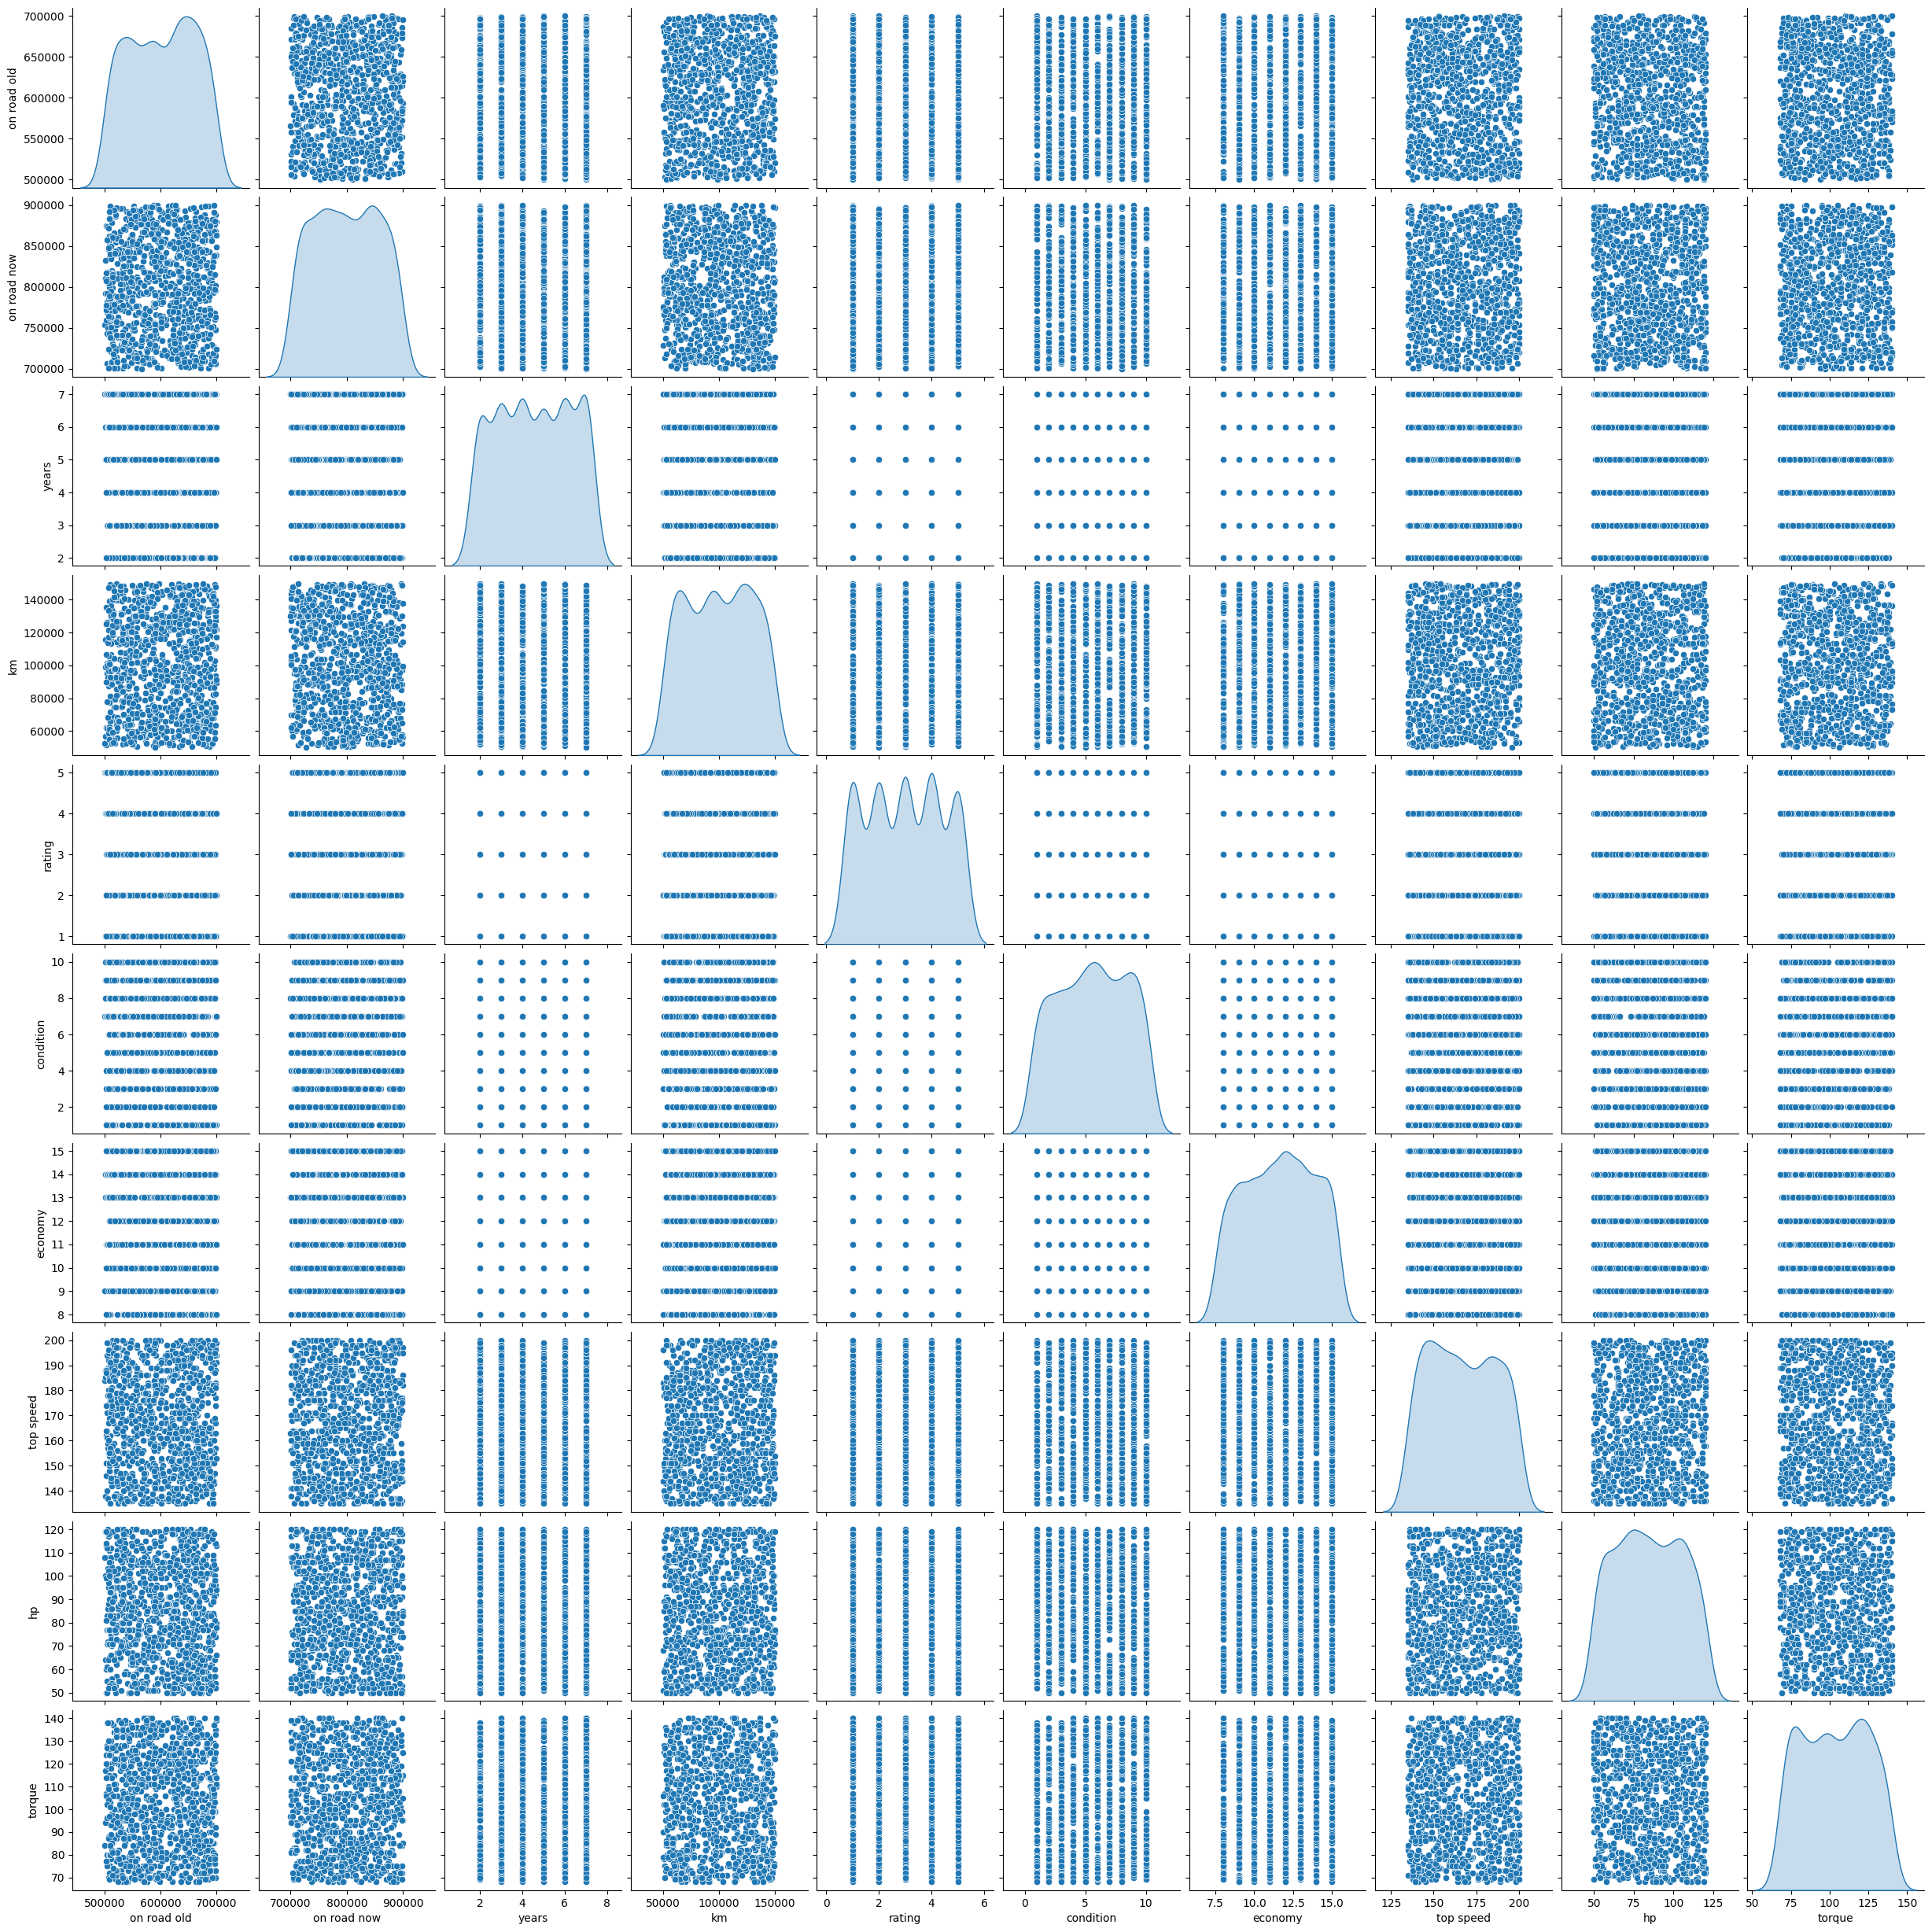

In [4]:
sns.pairplot(df[['on road old', 'on road now', 'years', 'km', 'rating', 'condition', 'economy', 'top speed', 'hp', 'torque']], diag_kind='kde');

In [5]:
# Correlation Matrix
corr = df.corr()
corr

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
v.id,1.000000,-0.029926,-0.030787,-0.034255,0.047400,-0.018263,-0.038548,0.047137,0.001613,-0.006997,-0.000632,-0.059460
on road old,-0.029926,1.000000,0.034113,0.007207,0.007488,-0.050717,-0.015682,-0.030097,-0.023816,-0.049266,0.008950,0.233035
on road now,-0.030787,0.034113,1.000000,0.004609,-0.053202,0.028280,-0.005043,-0.015880,0.012699,-0.012719,0.017955,0.282793
years,-0.034255,0.007207,0.004609,1.000000,-0.002089,0.027285,0.053579,0.050220,0.025148,-0.003272,0.028859,-0.011854
km,0.047400,0.007488,-0.053202,-0.002089,1.000000,-0.039930,-0.013640,0.032680,0.026450,-0.052918,0.013566,-0.935924
rating,-0.018263,-0.050717,0.028280,0.027285,-0.039930,1.000000,0.015943,-0.009757,-0.042222,-0.022623,0.004408,0.035038
condition,-0.038548,-0.015682,-0.005043,0.053579,-0.013640,0.015943,1.000000,0.058788,0.018472,-0.071552,0.047805,0.110108
economy,0.047137,-0.030097,-0.015880,0.050220,0.032680,-0.009757,0.058788,1.000000,-0.059402,-0.016782,0.041632,-0.034711
top speed,0.001613,-0.023816,0.012699,0.025148,0.026450,-0.042222,0.018472,-0.059402,1.000000,0.057827,-0.019697,-0.027993
hp,-0.006997,-0.049266,-0.012719,-0.003272,-0.052918,-0.022623,-0.071552,-0.016782,0.057827,1.000000,-0.013817,0.030238


In [6]:
# Convert the data into a tensor
tensor_data = tf.constant(df)
tensor_data = tf.cast(tensor_data, dtype=tf.float32)
tensor_data

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



<tf.Tensor: shape=(1000, 12), dtype=float32, numpy=
array([[1.000000e+00, 5.356510e+05, 7.981860e+05, ..., 7.300000e+01,
        1.230000e+02, 3.513180e+05],
       [2.000000e+00, 5.919110e+05, 8.610560e+05, ..., 7.400000e+01,
        9.500000e+01, 2.850015e+05],
       [3.000000e+00, 6.869900e+05, 7.707620e+05, ..., 5.300000e+01,
        9.700000e+01, 2.153860e+05],
       ...,
       [9.980000e+02, 6.463440e+05, 8.427330e+05, ..., 1.130000e+02,
        8.900000e+01, 4.058710e+05],
       [9.990000e+02, 5.355590e+05, 7.324390e+05, ..., 1.120000e+02,
        1.280000e+02, 7.439800e+04],
       [1.000000e+03, 5.901050e+05, 7.797430e+05, ..., 9.900000e+01,
        9.600000e+01, 4.149385e+05]], dtype=float32)>

In [7]:
# Shuffle the data
tensor_data = tf.random.shuffle(tensor_data, seed=42)
print(tensor_data[:5])

tf.Tensor(
[[7.30000e+01 5.32410e+05 8.03816e+05 3.00000e+00 5.21560e+04 4.00000e+00
  7.00000e+00 1.30000e+01 1.43000e+02 1.18000e+02 9.00000e+01 4.68543e+05]
 [6.60000e+02 5.87055e+05 8.77794e+05 6.00000e+00 1.06261e+05 2.00000e+00
  9.00000e+00 1.30000e+01 1.57000e+02 7.20000e+01 9.20000e+01 3.33278e+05]
 [5.80000e+01 6.65615e+05 8.78127e+05 7.00000e+00 7.98130e+04 3.00000e+00
  1.00000e+00 1.30000e+01 1.58000e+02 1.10000e+02 1.38000e+02 4.44625e+05]
 [6.73000e+02 5.15286e+05 8.15528e+05 2.00000e+00 1.18682e+05 1.00000e+00
  1.00000e+00 1.50000e+01 1.67000e+02 8.30000e+01 9.50000e+01 1.90949e+05]
 [6.94000e+02 5.13733e+05 8.06198e+05 6.00000e+00 1.47741e+05 3.00000e+00
  1.00000e+00 1.00000e+01 1.58000e+02 1.19000e+02 8.70000e+01 6.54675e+04]], shape=(5, 12), dtype=float32)


In [8]:
X = tensor_data[:, 3:-1]
y = tensor_data[:, -1]

In [9]:
print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (1000, 8)
y: (1000,)


In [10]:
print(X[:5])

tf.Tensor(
[[3.00000e+00 5.21560e+04 4.00000e+00 7.00000e+00 1.30000e+01 1.43000e+02
  1.18000e+02 9.00000e+01]
 [6.00000e+00 1.06261e+05 2.00000e+00 9.00000e+00 1.30000e+01 1.57000e+02
  7.20000e+01 9.20000e+01]
 [7.00000e+00 7.98130e+04 3.00000e+00 1.00000e+00 1.30000e+01 1.58000e+02
  1.10000e+02 1.38000e+02]
 [2.00000e+00 1.18682e+05 1.00000e+00 1.00000e+00 1.50000e+01 1.67000e+02
  8.30000e+01 9.50000e+01]
 [6.00000e+00 1.47741e+05 3.00000e+00 1.00000e+00 1.00000e+01 1.58000e+02
  1.19000e+02 8.70000e+01]], shape=(5, 8), dtype=float32)


In [11]:
y = tf.expand_dims(y, axis=-1)
print(y[:5])

tf.Tensor(
[[468543. ]
 [333278. ]
 [444625. ]
 [190949. ]
 [ 65467.5]], shape=(5, 1), dtype=float32)


## Data Splitting

In [12]:
# Define the proportions for splitting
train_ratio = 0.8  # 80% for training
val_ratio = 0.1  # 10% for validation
test_ratio = 0.1  # 10% for testing
data_size = len(X)

train_size = int(data_size * train_ratio)
val_size = int(data_size * (train_ratio + val_ratio))

In [13]:
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:val_size]
y_val = y[train_size:val_size]

X_test = X[val_size:]
y_test = y[val_size:]

In [14]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print()
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print()
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (800, 8)
y_train: (800, 1)

X_val: (100, 8)
y_val: (100, 1)

X_test: (100, 8)
y_test: (100, 1)


In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[-0.9094141 , -1.6599904 ,  0.7350792 ,  0.51440406,  0.5948634 ,
        -1.234589  ,  1.630573  , -0.65144074],
       [ 0.8214295 ,  0.20410237, -0.6992209 ,  1.2288538 ,  0.5948634 ,
        -0.50931257, -0.61571425, -0.5565391 ],
       [ 1.3983773 , -0.7071171 ,  0.01792916, -1.6289454 ,  0.5948634 ,
        -0.4575071 ,  1.2399144 ,  1.626198  ],
       [-1.486362  ,  0.63204616, -1.4163709 , -1.6289454 ,  1.4970238 ,
         0.00874201, -0.07855862, -0.4141867 ],
       [ 0.8214295 ,  1.6332229 ,  0.01792916, -1.6289454 , -0.7583771 ,
        -0.4575071 ,  1.6794053 , -0.79379314]], dtype=float32)>

In [19]:
print(X[:5])

tf.Tensor(
[[3.00000e+00 5.21560e+04 4.00000e+00 7.00000e+00 1.30000e+01 1.43000e+02
  1.18000e+02 9.00000e+01]
 [6.00000e+00 1.06261e+05 2.00000e+00 9.00000e+00 1.30000e+01 1.57000e+02
  7.20000e+01 9.20000e+01]
 [7.00000e+00 7.98130e+04 3.00000e+00 1.00000e+00 1.30000e+01 1.58000e+02
  1.10000e+02 1.38000e+02]
 [2.00000e+00 1.18682e+05 1.00000e+00 1.00000e+00 1.50000e+01 1.67000e+02
  8.30000e+01 9.50000e+01]
 [6.00000e+00 1.47741e+05 3.00000e+00 1.00000e+00 1.00000e+01 1.58000e+02
  1.19000e+02 8.70000e+01]], shape=(5, 8), dtype=float32)


## Linear Regression Model

In [20]:
model = keras.Sequential([
    InputLayer(input_shape=(8,)),
    normalizer,
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 8)                 17        
 on)                                                             
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34322 (134.07 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 17 (72.00 Byte)
________________

In [21]:
model.compile(loss=MeanAbsoluteError(), 
              optimizer=Adam(learning_rate=0.1), 
              metrics=RootMeanSquaredError())

In [22]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100, 
                    verbose=1)

Epoch 1/100
25/25 [==============================] - 1s 19ms/step - loss: 154918.6094 - root_mean_squared_error: 205159.7188 - val_loss: 56768.3945 - val_root_mean_squared_error: 69290.0547
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 51073.1562 - root_mean_squared_error: 63237.1641 - val_loss: 54440.7969 - val_root_mean_squared_error: 67398.1328
Epoch 3/100
25/25 [==============================] - 0s 8ms/step - loss: 48467.1719 - root_mean_squared_error: 60639.8008 - val_loss: 45249.0156 - val_root_mean_squared_error: 55662.1289
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 43689.1133 - root_mean_squared_error: 54248.9531 - val_loss: 42212.7188 - val_root_mean_squared_error: 52375.0430
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 41608.5508 - root_mean_squared_error: 51785.1914 - val_loss: 43729.8555 - val_root_mean_squared_error: 54244.0156
Epoch 6/100
25/25 [==============================] - 0s 8ms/st

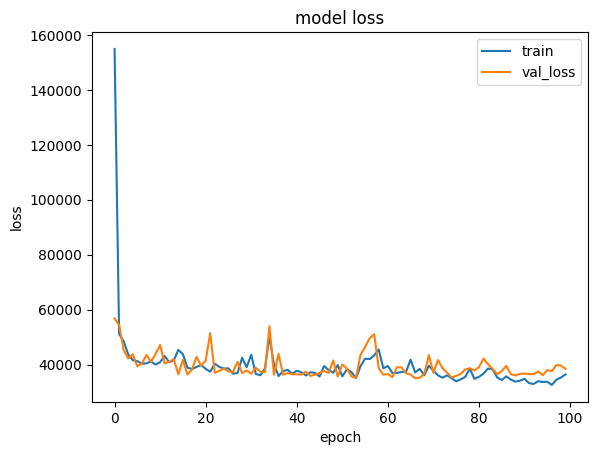

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

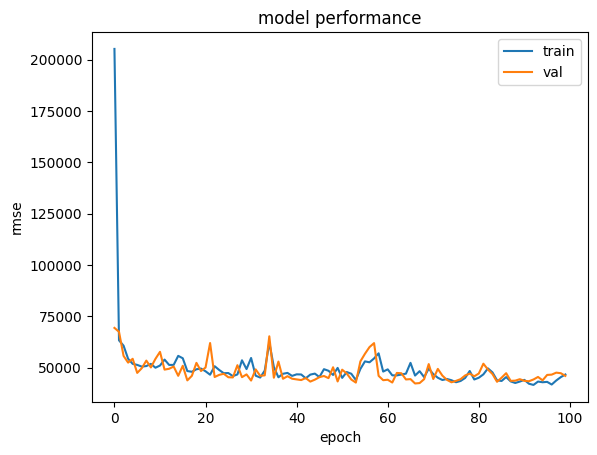

In [24]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

## Model Evaluation

In [25]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 6ms/step - loss: 35650.5234 - root_mean_squared_error: 44297.8555


[35650.5234375, 44297.85546875]

In [26]:
model.predict(tf.expand_dims(X_test[0], axis = 0 ))

1/1 [==============================] - 0s 151ms/step


array([[282677.72]], dtype=float32)

In [27]:
y_true = list(y_test[:,0].numpy())

In [28]:
y_pred = list(model.predict(X_test)[:,0])
print(y_pred)

4/4 [==============================] - 0s 9ms/step
[282677.72, 165844.84, 469998.25, 443434.6, 383559.97, 198121.06, 447357.97, 450822.47, 496011.03, 138855.69, 309954.72, 427601.22, 115859.37, 433667.53, 140824.9, 265940.88, 265553.4, 123447.2, 175207.98, 194014.88, 329639.47, 332635.66, 391716.1, 314767.9, 125803.47, 117474.49, 325470.22, 373688.1, 491964.75, 128972.95, 206189.16, 199597.56, 378685.4, 304985.22, 126600.625, 289296.1, 271497.66, 414780.72, 188453.83, 309651.94, 470603.66, 470142.22, 196172.62, 469570.34, 228997.75, 347559.9, 161179.11, 509177.03, 278589.53, 320583.78, 163894.98, 429120.1, 358740.53, 447778.72, 270403.28, 448912.88, 174658.62, 359001.2, 115537.805, 213597.25, 255118.95, 428612.22, 456595.94, 167155.72, 197696.03, 530593.75, 213130.28, 338690.03, 480436.16, 214538.86, 230254.06, 312803.34, 276164.34, 162954.53, 358466.3, 114264.55, 192454.67, 119752.26, 255388.94, 265775.66, 494861.47, 125317.67, 427938.97, 373502.97, 298157.9, 337796.1, 409714.22, 1580

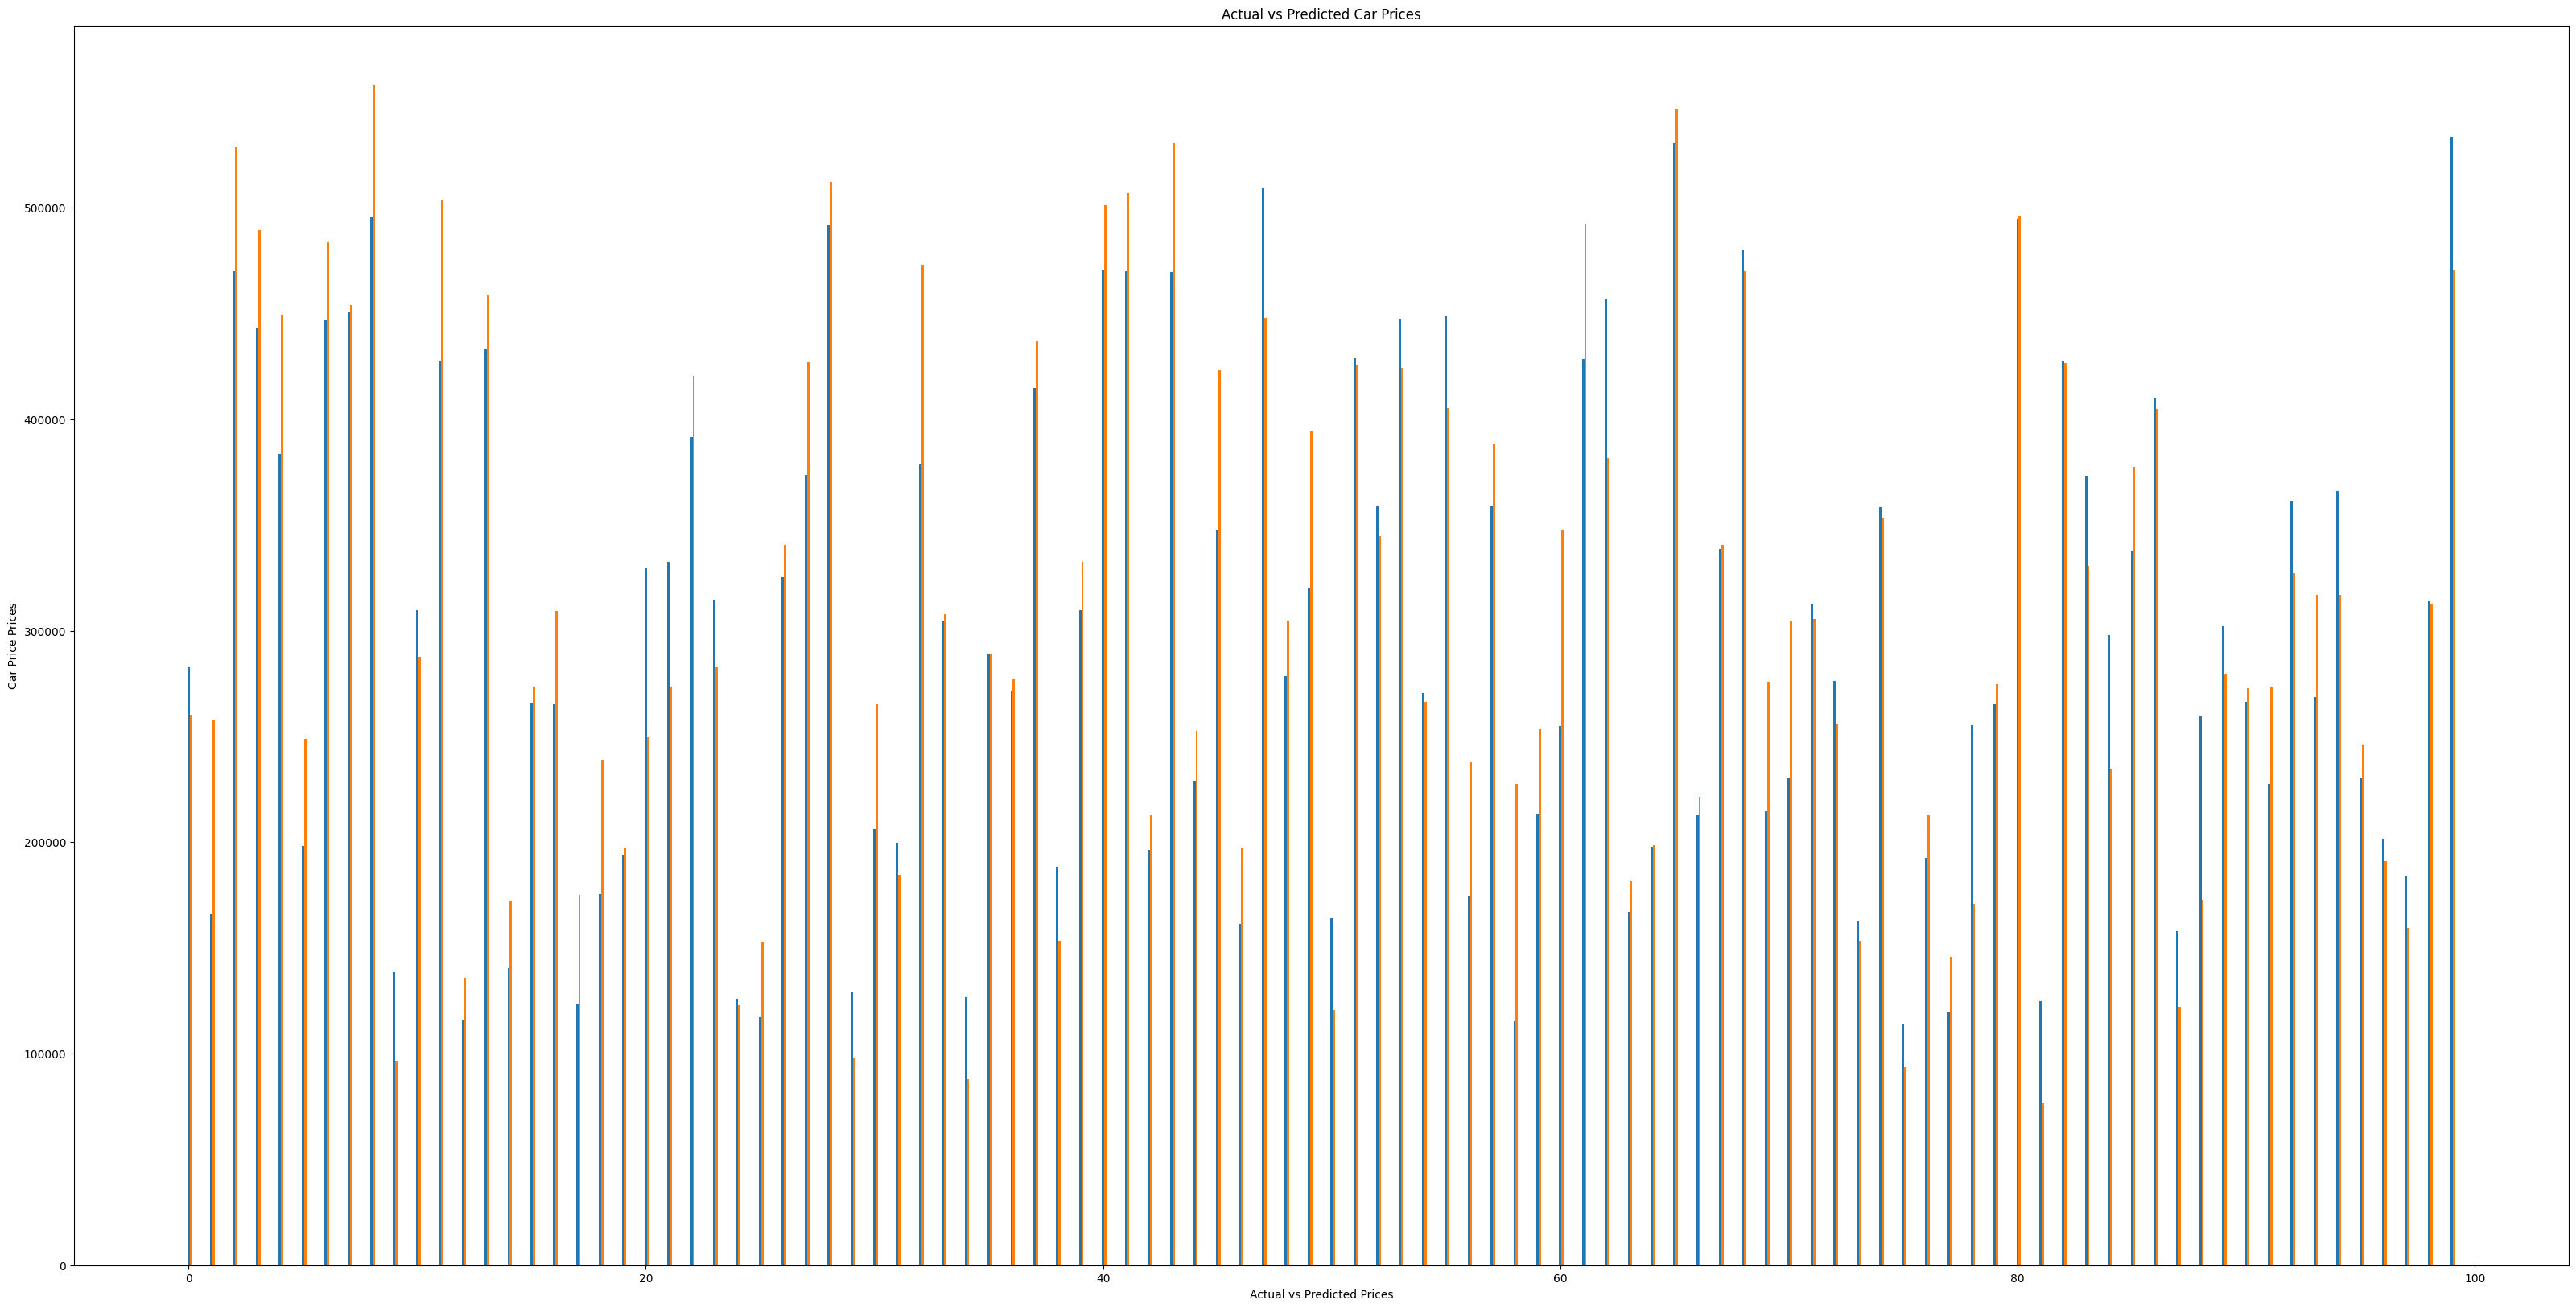

In [29]:
ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.1

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label='Actual Car Price')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')
plt.title('Actual vs Predicted Car Prices')

plt.show()